# 基于价值投资的策略

选择的投资标的是沪深 300 指数，估值相比个股来说更加稳定。
利用沪深 300 整体的市盈率估值分位数，通过回测，看能否找到一个可行的价值投资策略。

策略逻辑：当沪深 300 的市盈率估值分位数超过 80% 的时候，平仓；然后等分位数重新落回到 50% 以下时，再恢复满仓。
这个策略非常简单可执行，我们来看一看它在过去 11 年的表现。


In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

工具函数

In [2]:
from shared.tools import get_drawdown, cal_period_perf_indicator, datestr2dtdate, date_count_in_month

pctrank = lambda x: x.rank(pct=True).iloc[-1]

加载回测数据

In [3]:
index_data = pd.read_csv('./res/指数估值历史数据.csv').set_index('datetime')
index_data.index = [datestr2dtdate(e) for e in index_data.index]

设置回测参数

In [4]:
# index_id = 'hs300'
index_id = 'csi500'
# 计算 PE 分位数滑动窗口长度，每年 242 交易日
pe_rank_window = 242 * 5
# 退出 和 进入 市场的 PE 分为数
undervalued_pe = 0.35
overvalued_pe = 0.85


回测

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.040203  0.257214  0.156304 -0.651957  0.061666  0.586085
stgy   0.052236  0.194423  0.268675 -0.498767  0.104731  0.814600


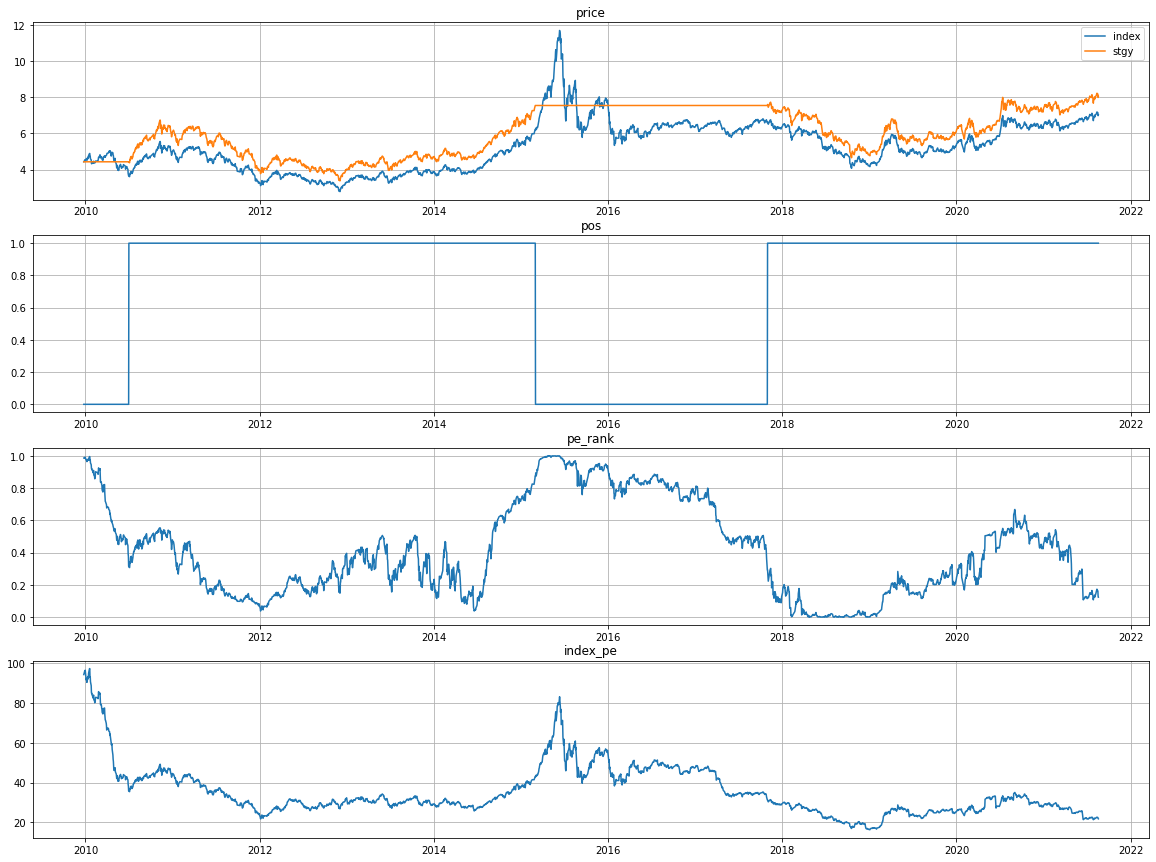

In [5]:
df = index_data.loc[:, [index_id]]
df['index_pe'] = index_data[index_id + '_pe']
df['index_ret'] = df[index_id].pct_change()
df['index'] = (1 + df['index_ret']).cumprod().fillna(1)
df['pe_rank'] = df['index_pe'].rolling(window=pe_rank_window).apply(pctrank)
df['pos'] = np.nan
for t in range(pe_rank_window, len(df.index)):
    # 策略：高于 overvalued_pe 则空仓，回到 undervalued_pe 则重新满仓，否则保持昨仓
    prev_pe_rank = df.loc[df.index[t - 1], 'pe_rank']
    prev_pos = df.loc[df.index[t - 1], 'pos']
    prev_pos = 1 if np.isnan(prev_pos) else prev_pos
    df.loc[df.index[t], 'pos'] = 0 if prev_pe_rank > overvalued_pe else 1 if prev_pe_rank < undervalued_pe else prev_pos

# 计算回测业绩
backtest_start_date = index_data.index[pe_rank_window]
df['stgy_ret'] = df['pos'] * df['index_ret']
df['stgy'] = (1 + df['stgy_ret']).cumprod() * df.loc[backtest_start_date, 'index']

price_df = df.loc[backtest_start_date:, ['index', 'stgy']]
# 绘制回测结果走势图
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(4, 1, 1)
price_df.plot(ax=ax1, grid=True, title='price')
ax2 = fig.add_subplot(4, 1, 2)
df.loc[backtest_start_date:, 'pos'].plot(ax=ax2, grid=True, title='pos')
ax3 = fig.add_subplot(4, 1, 3)
df.loc[backtest_start_date:, 'pe_rank'].plot(ax=ax3, grid=True, title='pe_rank')
ax4 = fig.add_subplot(4, 1, 4)
df.loc[backtest_start_date:, 'index_pe'].plot(ax=ax4, grid=True, title='index_pe')

# 计算回测业绩指标表
res = cal_period_perf_indicator(df.loc[backtest_start_date:, ['index', 'stgy']])
res['TotalRet'] = price_df.iloc[-1] / price_df.iloc[0] - 1
print(res)